# Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/cleaned_student_depression_dataset.csv')
#df.head()

In [3]:
print(df['Depression'].value_counts(normalize=True) * 100)

Depression
1    58.519237
0    41.480763
Name: proportion, dtype: float64


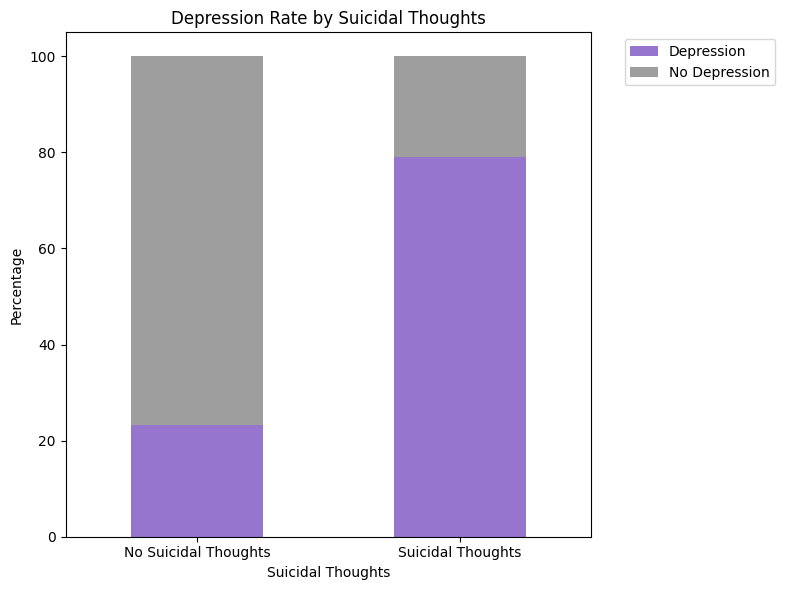

Depression,1,0
Suicidal_Thoughts,,
0,23.183729,76.816271
1,79.040318,20.959682


In [4]:
ct = pd.crosstab(df['Suicidal_Thoughts'], df['Depression'], normalize='index') * 100

ct = ct[[1, 0]]

ct.plot(kind='bar', stacked=True, color=['#9575cd', '#9e9e9e'], figsize=(8, 6))
plt.xlabel('Suicidal Thoughts')
plt.ylabel('Percentage')
plt.title('Depression Rate by Suicidal Thoughts')
plt.xticks([0, 1], ['No Suicidal Thoughts', 'Suicidal Thoughts'], rotation=0)
plt.legend(['Depression', 'No Depression'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
ct

## Feature Selection: Suicidal Thoughts

**We see a strong correlation**: 79% of students with suicidal thoughts have depression, compared to just 23% without (dataset average: 58%). I've decided to exclude this feature from here onwards because:
- Too closely correlated with the target variable
- Early intervention aims to identify at-risk students before reaching this critical point

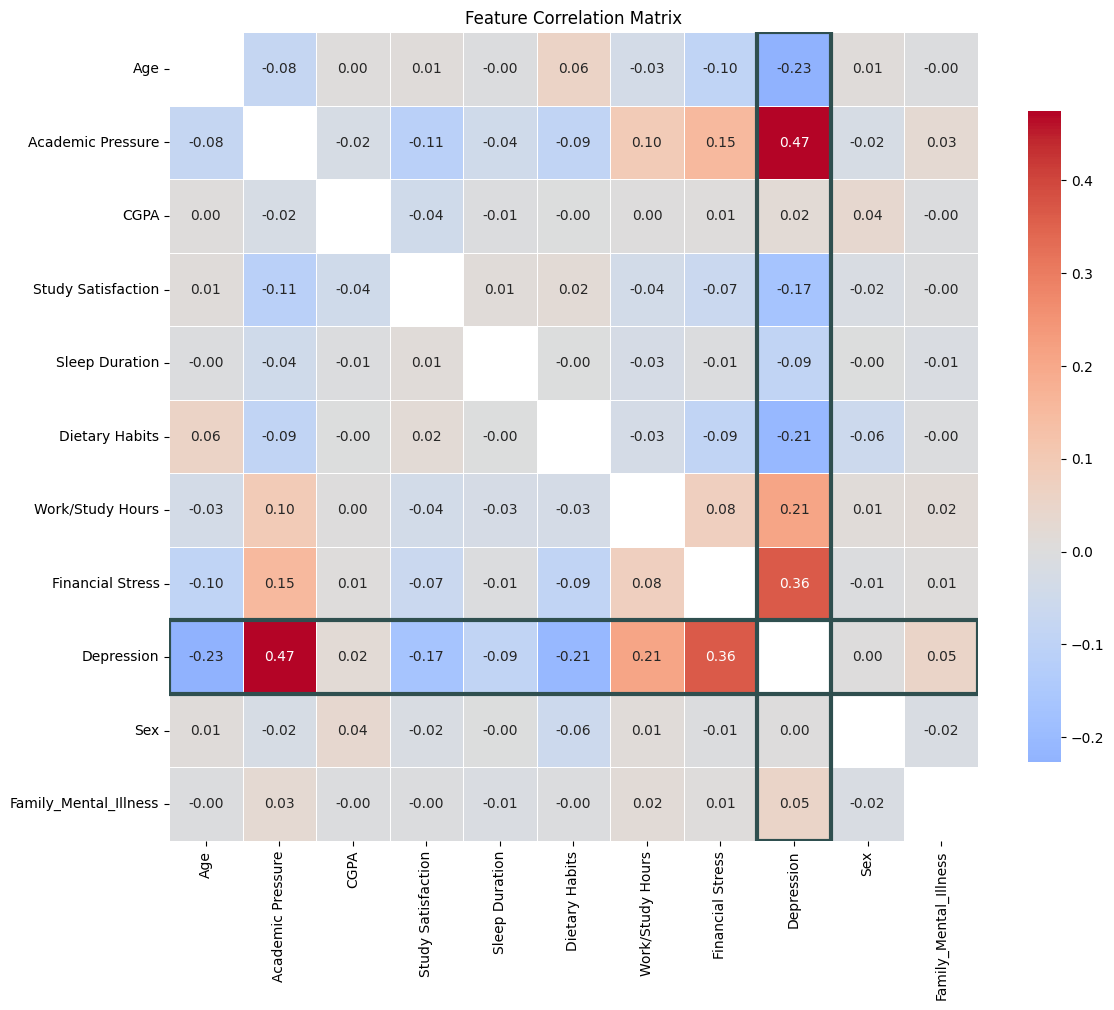

In [10]:
df_base_reduced = df.drop(columns=['City', 'Degree', 'Suicidal_Thoughts'])
corr_matrix = df_base_reduced.corr()

mask = np.zeros_like(corr_matrix, dtype=bool)
np.fill_diagonal(mask, True)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                 square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                 mask=mask)

depression_idx = corr_matrix.columns.get_loc('Depression')

ax.add_patch(plt.Rectangle((0, depression_idx), len(corr_matrix), 1, 
                           fill=False, edgecolor='darkslategrey', lw=3))
ax.add_patch(plt.Rectangle((depression_idx, 0), 1, len(corr_matrix), 
                           fill=False, edgecolor='darkslategrey', lw=3))

plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Key Observations

- Academic Pressure (0.47) and Financial Stress (0.36) have the strongest correlations with Depression, which aligns with expectations. 
- Interestingly, Sleep Duration (-0.09) and Sex (0.00) show minimal correlation with Depression, which is unexpected.
- And there's a small negative correlation with Age (-0.23), suggesting younger students are more likely to experience depression.

Let's examine these relationships in more detail:

### Key Observations

Importantly, features show minimal correlation with each other, indicating no multicollinearity concerns that would require feature removal.

- The correlation matrix shows that Academic Pressure (0.47) and Financial Stress (0.36) have the strongest correlations with Depression, which aligns with my expectations. 
- Interestingly, Sleep Duration (-0.09) and Sex (0.00) show minimal correlation with Depression, which is unexpected.
- And there's a small negative correlation with Age (-0.23), suggesting younger students are more likely to experience depression.

Let's examine these relationships in more detail:

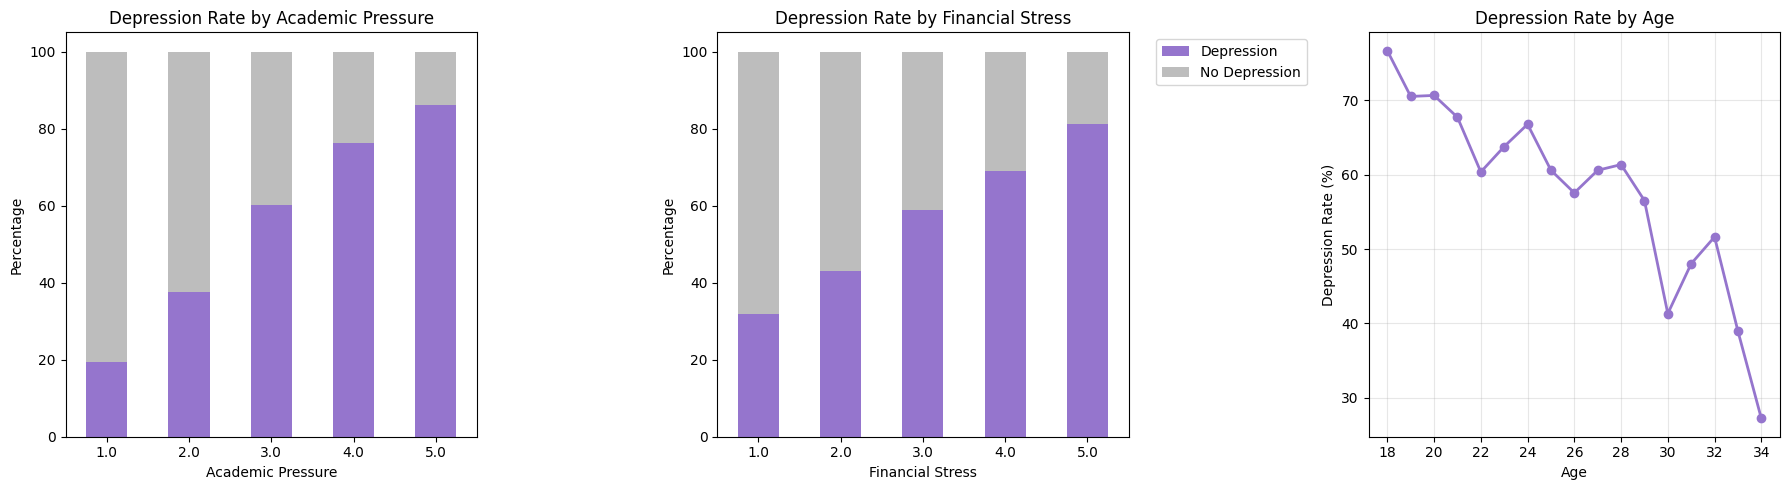

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Academic Pressure vs Depression
ct_ap = pd.crosstab(df_base_reduced['Academic Pressure'], df_base_reduced['Depression'], normalize='index') * 100
ct_ap = ct_ap[[1, 0]]
ct_ap.plot(kind='bar', stacked=True, color=['#9575cd', '#bdbdbd'], ax=axes[0], legend=False)
axes[0].set_xlabel('Academic Pressure')
axes[0].set_ylabel('Percentage')
axes[0].set_title('Depression Rate by Academic Pressure')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Financial Stress vs Depression
ct_fs = pd.crosstab(df_base_reduced['Financial Stress'], df_base_reduced['Depression'], normalize='index') * 100
ct_fs = ct_fs[[1, 0]]
ct_fs.plot(kind='bar', stacked=True, color=['#9575cd', '#bdbdbd'], ax=axes[1], legend=False)
axes[1].set_xlabel('Financial Stress')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Depression Rate by Financial Stress')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Age vs Depression (filtered for only Ages with >50 people (18-34))
age_counts = df_base_reduced['Age'].value_counts()
valid_ages = age_counts[age_counts > 50].index

df_filtered_age = df_base_reduced[df_base_reduced['Age'].isin(valid_ages)]
age_depression = df_filtered_age.groupby('Age')['Depression'].mean() * 100

axes[2].plot(age_depression.index, age_depression.values, marker='o', linewidth=2, markersize=6, color='#9575cd')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Depression Rate (%)')
axes[2].set_title('Depression Rate by Age')
axes[2].grid(alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#9575cd', label='Depression'),
                   Patch(facecolor='#bdbdbd', label='No Depression')]
axes[1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Academic Pressure shows the strongest relationship:**
- Clear upward trend: depression rate increases from 20% (low pressure) to 87% (highest pressure)
- This 4.5x increase demonstrates Academic Pressure as a critical predictor

**Financial Stress follows a similar pattern:**
- Depression rate rises from 32% (low stress) to 81% (highest stress)
- Slightly weaker effect than Academic Pressure but still substantial

**Age shows an inverse relationship:**
- Younger students (18-22) experience depression at rates of 60-75%
- Depression rate drops significantly for students aged 30+ (27-52%)
- This could indicate that age/maturity provides resilience, though differences in how younger vs older students understand or report depression may also play a role

**Next step:**
Given that Academic Pressure and Financial Stress both show strong relationships with Depression, let's examine how they interact when combined.

In [16]:
df_filtered_age['Age'].value_counts().sort_index()

Age
18.0    1585
19.0    1560
20.0    2235
21.0    1722
22.0    1158
23.0    1637
24.0    2254
25.0    1779
26.0    1152
27.0    1459
28.0    2127
29.0    1946
30.0    1142
31.0    1422
32.0    1255
33.0    1891
34.0    1464
Name: count, dtype: int64

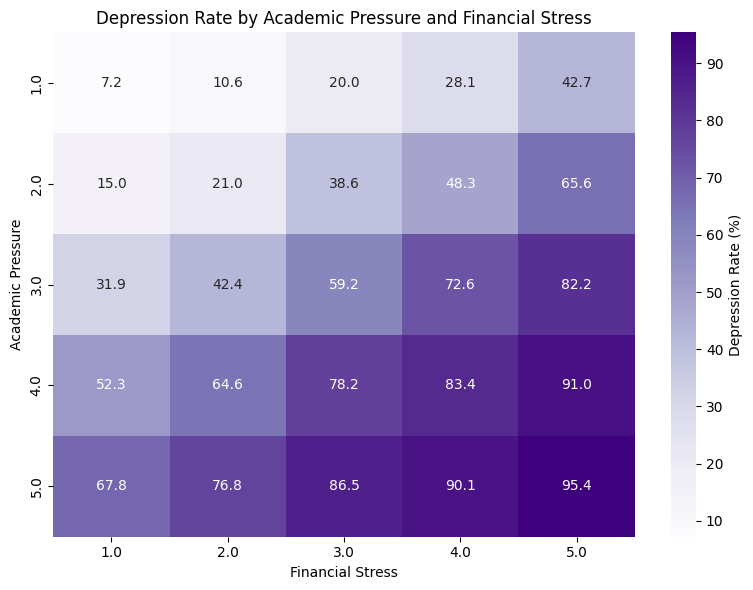

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

combo_depression = df_base_reduced.groupby(['Academic Pressure', 'Financial Stress'])['Depression'].mean() * 100
combo_pivot = combo_depression.unstack()

sns.heatmap(combo_pivot, annot=True, fmt='.1f', cmap='Purples', cbar_kws={'label': 'Depression Rate (%)'})
ax.set_xlabel('Financial Stress')
ax.set_ylabel('Academic Pressure')
ax.set_title('Depression Rate by Academic Pressure and Financial Stress')

plt.tight_layout()
plt.show()